# Visualization

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import autograd.numpy as np
import matplotlib.pyplot as plt

from counterfactualgp.gp import GP
from counterfactualgp.mean import LinearWithBsplinesBasis
from counterfactualgp.treatment import DummyTreatment, Treatment
from counterfactualgp.mpp import BinaryActionModel
from counterfactualgp.cov import iid_cov, se_cov

In [2]:
with open('dataset/data_set_bspline_3classes.pkl', 'rb') as fin:
    data = pickle.load(fin)

In [3]:
low, high = 0.0, 24.0
num_basis = 5
bsplines_degree = 3

In [4]:
def predict(gp, y, x, x_star):
    t, rx = x
    t_star, rx_star = x_star
    yhat, cov_hat = gp.predict((t_star, rx_star), y, (t, rx))
        
    return yhat, cov_hat

In [5]:
def draw_samples(gp, samples, t_star, rx_star, nrow=3, ncol=3, title='',
                 truncated_time=None, copy_truncated_rx=False):
    
    def _concat_x(t1, rx1, t2, rx2):
        t = np.concatenate([t1, t2])
        rx = np.concatenate([rx1, rx2])
        idx = np.argsort(t)
        return t[idx], rx[idx]
    
    # reset `rx_star` if not truncated
    if truncated_time is not None:
        rx_star[t_star <= truncated_time] = 0
    else:
        rx_star = np.zeros(rx_star.shape[0])
    
    fig, axes = plt.subplots(nrow, ncol, sharex=True, figsize=(12,6), sharey=True)
    for i in range(nrow):
        for j in range(ncol):
            idx = i*nrow+j            
            y, x = samples[idx]
            t, rx = x
            
            if truncated_time is not None:
                _y = y[t <= truncated_time]
                _t = t[t <= truncated_time]
                _rx = rx[t <= truncated_time]
                if copy_truncated_rx:
                    _t_star, _rx_star = _concat_x(t, rx, t_star, rx_star)
                else:
                    _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            else:
                _y, _t, _rx = y, t, rx
                _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            
            yhat, cov_hat = predict(gp, _y, (_t, _rx), (_t_star, _rx_star))
            y_std = np.diag(cov_hat)
            
            axes[i, j].plot(_t_star, yhat, color='b')
            axes[i, j].scatter(t, y, marker='o', color='r')
            for _tt, _rx in zip(t, rx):
                if _rx == 1:
                    axes[i, j].axvline(x=_tt, color = 'y')
            axes[i, j].fill_between(_t_star, yhat - y_std, yhat + y_std,
                                 alpha=0.2, color='k')
            if truncated_time is not None:
                axes[i, j].axvline(x=truncated_time, color='r', ls='--')
    fig.suptitle(title)
    plt.show()

## Baseline GP without treatment

In [8]:
m = LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high))
tr = []
tr.append( (1.0, DummyTreatment()) )
bgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
bgp.fit(data['training2'], init = False)
print(bgp.params)

obj= 5172.093505021836
obj= 5108.271061553546
obj= 5093.58607140126
obj= 5065.668715385415
obj= 4819.282659977127
obj= 4501.5814620507745
obj= 4482.47337073403
obj= 4481.928642526786
obj= 4481.866639475449
obj= 4481.84282802141
obj= 4481.8427795390635
obj= 4481.842779060398
obj= 4481.842779049519
obj= 4481.842779049489
obj= 4481.842779049487
{'ln_cov_l_F': array([0.]), 'linear_with_bsplines_basis_mean_coef': array([-4.96327752,  1.93202105,  0.29571434,  0.18211345,  0.36652351]), 'linear_with_bsplines_basis_degree_F': array([0.]), 'ln_cov_a_F': array([0.]), 'ln_cov_y': array([-2.29257482])}


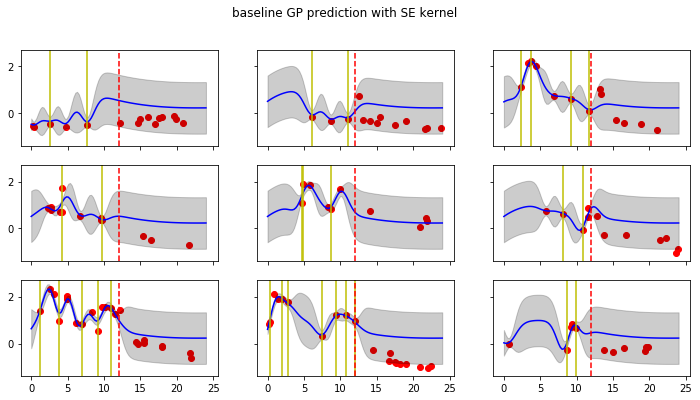

In [9]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', data['truncated_time'])

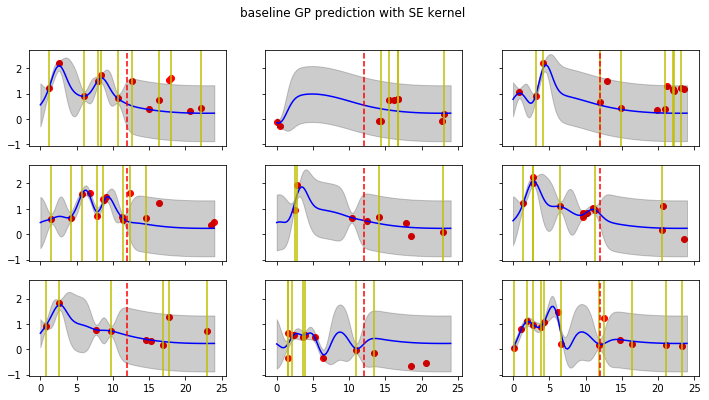

In [10]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', 
             data['truncated_time'], copy_truncated_rx=True)

## Baseline GP with treatment

In [11]:
m = LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high))
tr = []
tr.append( (1.0, Treatment(2.0)) )
bgp_rx = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
bgp_rx.fit(data['training2'], init = False)
print(bgp_rx.params)

obj= 5047.184530152005
obj= 3741.3515469505464
obj= 3721.45923858432
obj= 3721.179362199496
obj= 3720.691306813211
obj= 3716.7686175078943
obj= 3713.9503774273344
obj= 3713.6823298503023
obj= 3713.651926679141
obj= 3713.643495591339
obj= 3713.643088313294
obj= 3713.6430837186817
obj= 3713.6430836993277
obj= 3713.6430836987433
obj= 3713.6430836987383
{'ln_cov_l_F': array([0.]), 'linear_with_bsplines_basis_mean_coef': array([-1.63212877,  1.1783987 ,  0.12595539, -0.13996613, -0.12918574]), 'linear_with_bsplines_basis_degree_F': array([0.]), 'effects_window_F': array([2.]), 'treatment': array([0.53047862]), 'ln_cov_y': array([-2.94221228]), 'ln_cov_a_F': array([0.])}


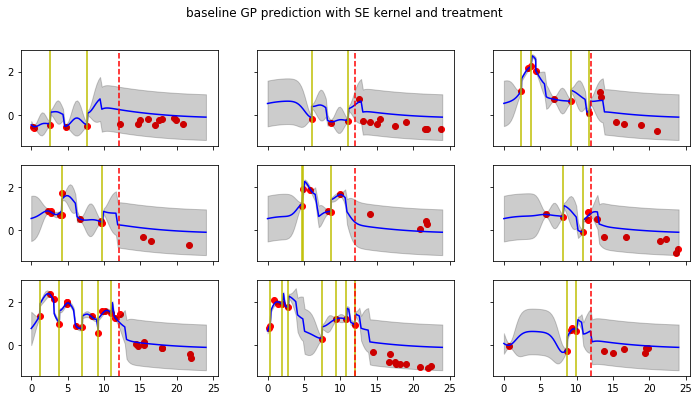

In [12]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

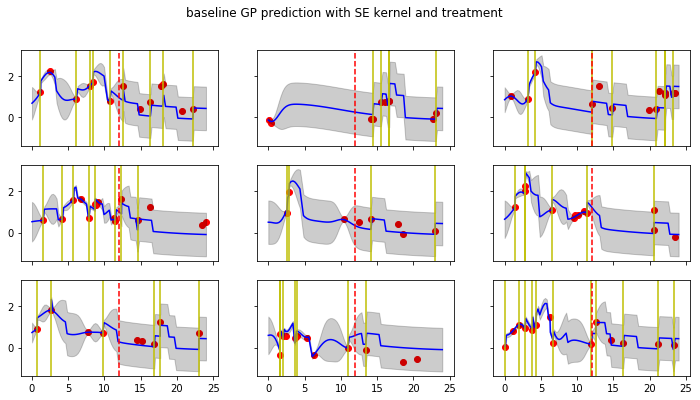

In [13]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Counterfactual GP

In [14]:
m = LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high))
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
cgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=ac)
cgp.fit(data['training2'], init = False)
print(cgp.params)

obj= [8060.46203138]
obj= [7488.38676326]
obj= [7356.48734348]
obj= [7334.35313593]
obj= [7319.74188348]
obj= [7198.81605311]
obj= [7014.42477714]
obj= [6872.83344874]
obj= [6870.78892778]
obj= [6870.61760698]
obj= [6870.58081517]
obj= [6870.57352752]
obj= [6870.57347566]
obj= [6870.57347518]
obj= [6870.57347516]
obj= [6870.57347516]
{'ln_cov_l_F': array([0.]), 'linear_with_bsplines_basis_mean_coef': array([-2.11545859,  1.28354713,  0.11735672, -0.08626169, -0.36879375]), 'linear_with_bsplines_basis_degree_F': array([0.]), 'ln_cov_a_F': array([0.]), 'effects_window_F': array([2.]), 'treatment': array([0.60686055]), 'action': array([0.35276248]), 'ln_cov_y': array([-3.06457102])}


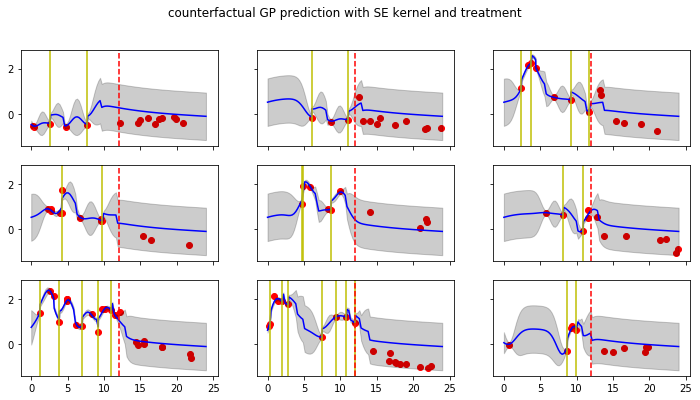

In [15]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

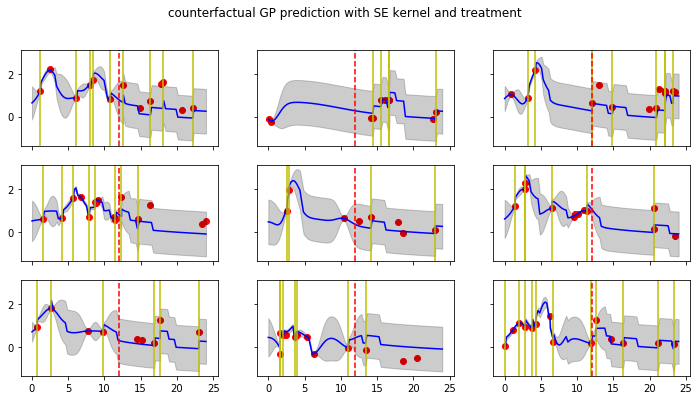

In [16]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

# MSE

In [17]:
def MSE(gp, samples, truncated_time):
    '''
    Calculate the MSE metric over points after `truncated_time`.
    '''
    s = 0.0
    for y, x in samples:
        t, rx = x
        idx = t <= truncated_time
        _y = y[idx]
        _t = t[idx]
        _rx = rx[idx]

        yhat, cov_hat = predict(gp, _y, (_t, _rx), (t, rx))
        s += np.sum((yhat[~idx] - y[~idx]) **2) / y[~idx].shape[0]
    
    return s / len(samples)

In [18]:
print('bgp', MSE(bgp, data['testing1'], data['truncated_time']))
print('bgp_rx', MSE(bgp_rx, data['testing1'], data['truncated_time']))
print('cgp_rx', MSE(cgp, data['testing1'], data['truncated_time']))

bgp 0.3228047402940801
bgp_rx 0.17161638793099881
cgp_rx 0.17912951635903324


In [19]:
print('bgp', MSE(bgp, data['training2'], data['truncated_time']))
print('bgp_rx', MSE(bgp_rx, data['training2'], data['truncated_time']))
print('cgp_rx', MSE(cgp, data['training2'], data['truncated_time']))

bgp 0.40099785382479475
bgp_rx 0.20507792162128607
cgp_rx 0.24231523239629274
